In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    
print('Done!')

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [01:26<00:00,  7.75it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 85.25it/s]


Done!


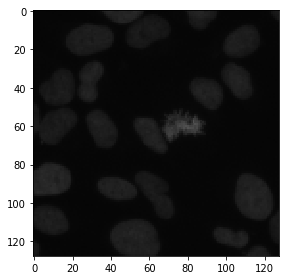

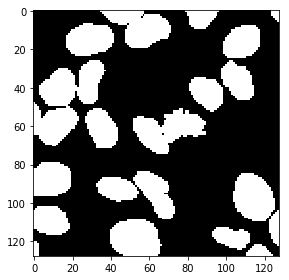

In [6]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [17]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)


u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)


outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 128, 128, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 128, 128, 16) 448         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 128, 128, 16) 0           conv2d_56[0][0]                  
__________________________________________________________________________________________________
conv2d_57 

__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 128, 128, 16) 4624        concatenate_15[0][0]             
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 128, 128, 16) 0           conv2d_72[0][0]                  
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 128, 128, 16) 2320        dropout_35[0][0]                 
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 128, 128, 1)  17          conv2d_73[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [22]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50)
                    #callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - ETA: 1:25 - loss: 0.2505 - mean_iou: 0.0000e+ - ETA: 43s - loss: 0.2773 - mean_iou: 0.2924     - ETA: 29s - loss: 0.2462 - mean_iou: 0.396 - ETA: 22s - loss: 0.2393 - mean_iou: 0.454 - ETA: 17s - loss: 0.2347 - mean_iou: 0.492 - ETA: 14s - loss: 0.2238 - mean_iou: 0.518 - ETA: 12s - loss: 0.2175 - mean_iou: 0.538 - ETA: 11s - loss: 0.2197 - mean_iou: 0.552 - ETA: 9s - loss: 0.2098 - mean_iou: 0.564 - ETA: 8s - loss: 0.2100 - mean_iou: 0.57 - ETA: 8s - loss: 0.2077 - mean_iou: 0.58 - ETA: 7s - loss: 0.2039 - mean_iou: 0.58 - ETA: 6s - loss: 0.2039 - mean_iou: 0.59 - ETA: 6s - loss: 0.2040 - mean_iou: 0.60 - ETA: 5s - loss: 0.2093 - mean_iou: 0.60 - ETA: 5s - loss: 0.2052 - mean_iou: 0.60 - ETA: 4s - loss: 0.2062 - mean_iou: 0.61 - ETA: 4s - loss: 0.2045 - mean_iou: 0.61 - ETA: 4s - loss: 0.2002 - mean_iou: 0.61 - ETA: 3s - loss: 0.1961 - mean_iou: 0.62 - ETA: 3s - loss: 0.1932 - mean_iou: 

603/603 [==============================] - ETA: 3s - loss: 0.0836 - mean_iou: 0.76 - ETA: 3s - loss: 0.0793 - mean_iou: 0.76 - ETA: 3s - loss: 0.0853 - mean_iou: 0.76 - ETA: 3s - loss: 0.0842 - mean_iou: 0.76 - ETA: 3s - loss: 0.0877 - mean_iou: 0.76 - ETA: 2s - loss: 0.0957 - mean_iou: 0.76 - ETA: 2s - loss: 0.0972 - mean_iou: 0.76 - ETA: 2s - loss: 0.0997 - mean_iou: 0.76 - ETA: 2s - loss: 0.1002 - mean_iou: 0.76 - ETA: 2s - loss: 0.0973 - mean_iou: 0.76 - ETA: 2s - loss: 0.0973 - mean_iou: 0.76 - ETA: 2s - loss: 0.0992 - mean_iou: 0.76 - ETA: 2s - loss: 0.1010 - mean_iou: 0.76 - ETA: 2s - loss: 0.1015 - mean_iou: 0.76 - ETA: 2s - loss: 0.0996 - mean_iou: 0.76 - ETA: 2s - loss: 0.0986 - mean_iou: 0.76 - ETA: 1s - loss: 0.0967 - mean_iou: 0.76 - ETA: 1s - loss: 0.0981 - mean_iou: 0.76 - ETA: 1s - loss: 0.0992 - mean_iou: 0.76 - ETA: 1s - loss: 0.0984 - mean_iou: 0.76 - ETA: 1s - loss: 0.0972 - mean_iou: 0.76 - ETA: 1s - loss: 0.0985 - mean_iou: 0.76 - ETA: 1s - loss: 0.0984 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0758 - mean_iou: 0.79 - ETA: 3s - loss: 0.0786 - mean_iou: 0.79 - ETA: 3s - loss: 0.0868 - mean_iou: 0.79 - ETA: 3s - loss: 0.0902 - mean_iou: 0.79 - ETA: 3s - loss: 0.0934 - mean_iou: 0.79 - ETA: 3s - loss: 0.0989 - mean_iou: 0.79 - ETA: 2s - loss: 0.0964 - mean_iou: 0.79 - ETA: 2s - loss: 0.0986 - mean_iou: 0.79 - ETA: 2s - loss: 0.0964 - mean_iou: 0.79 - ETA: 2s - loss: 0.0933 - mean_iou: 0.79 - ETA: 2s - loss: 0.0907 - mean_iou: 0.79 - ETA: 2s - loss: 0.0907 - mean_iou: 0.79 - ETA: 2s - loss: 0.0877 - mean_iou: 0.79 - ETA: 2s - loss: 0.0866 - mean_iou: 0.80 - ETA: 2s - loss: 0.0877 - mean_iou: 0.80 - ETA: 2s - loss: 0.0876 - mean_iou: 0.80 - ETA: 2s - loss: 0.0878 - mean_iou: 0.80 - ETA: 1s - loss: 0.0888 - mean_iou: 0.80 - ETA: 1s - loss: 0.0889 - mean_iou: 0.80 - ETA: 1s - loss: 0.0891 - mean_iou: 0.80 - ETA: 1s - loss: 0.0881 - mean_iou: 0.80 - ETA: 1s - loss: 0.0875 - mean_iou: 0.80 - ETA: 1s - loss: 0.0884 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0755 - mean_iou: 0.81 - ETA: 3s - loss: 0.0755 - mean_iou: 0.81 - ETA: 3s - loss: 0.0741 - mean_iou: 0.81 - ETA: 3s - loss: 0.0701 - mean_iou: 0.81 - ETA: 3s - loss: 0.0648 - mean_iou: 0.81 - ETA: 3s - loss: 0.0722 - mean_iou: 0.81 - ETA: 2s - loss: 0.0768 - mean_iou: 0.81 - ETA: 2s - loss: 0.0790 - mean_iou: 0.81 - ETA: 2s - loss: 0.0779 - mean_iou: 0.81 - ETA: 2s - loss: 0.0788 - mean_iou: 0.81 - ETA: 2s - loss: 0.0803 - mean_iou: 0.81 - ETA: 2s - loss: 0.0820 - mean_iou: 0.81 - ETA: 2s - loss: 0.0798 - mean_iou: 0.81 - ETA: 2s - loss: 0.0805 - mean_iou: 0.81 - ETA: 2s - loss: 0.0802 - mean_iou: 0.81 - ETA: 2s - loss: 0.0802 - mean_iou: 0.81 - ETA: 2s - loss: 0.0808 - mean_iou: 0.81 - ETA: 1s - loss: 0.0840 - mean_iou: 0.81 - ETA: 1s - loss: 0.0816 - mean_iou: 0.81 - ETA: 1s - loss: 0.0803 - mean_iou: 0.81 - ETA: 1s - loss: 0.0792 - mean_iou: 0.81 - ETA: 1s - loss: 0.0798 - mean_iou: 0.81 - ETA: 1s - loss: 0.0797 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0811 - mean_iou: 0.82 - ETA: 3s - loss: 0.0819 - mean_iou: 0.82 - ETA: 3s - loss: 0.0735 - mean_iou: 0.82 - ETA: 3s - loss: 0.0737 - mean_iou: 0.82 - ETA: 3s - loss: 0.0742 - mean_iou: 0.82 - ETA: 3s - loss: 0.0703 - mean_iou: 0.82 - ETA: 3s - loss: 0.0686 - mean_iou: 0.82 - ETA: 2s - loss: 0.0701 - mean_iou: 0.82 - ETA: 2s - loss: 0.0662 - mean_iou: 0.82 - ETA: 2s - loss: 0.0687 - mean_iou: 0.82 - ETA: 2s - loss: 0.0699 - mean_iou: 0.82 - ETA: 2s - loss: 0.0721 - mean_iou: 0.82 - ETA: 2s - loss: 0.0735 - mean_iou: 0.82 - ETA: 2s - loss: 0.0743 - mean_iou: 0.82 - ETA: 2s - loss: 0.0743 - mean_iou: 0.82 - ETA: 2s - loss: 0.0750 - mean_iou: 0.82 - ETA: 2s - loss: 0.0757 - mean_iou: 0.82 - ETA: 1s - loss: 0.0744 - mean_iou: 0.82 - ETA: 1s - loss: 0.0730 - mean_iou: 0.82 - ETA: 1s - loss: 0.0722 - mean_iou: 0.82 - ETA: 1s - loss: 0.0720 - mean_iou: 0.82 - ETA: 1s - loss: 0.0725 - mean_iou: 0.82 - ETA: 1s - loss: 0.0728 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0844 - mean_iou: 0.83 - ETA: 3s - loss: 0.0741 - mean_iou: 0.83 - ETA: 3s - loss: 0.0731 - mean_iou: 0.83 - ETA: 3s - loss: 0.0704 - mean_iou: 0.83 - ETA: 3s - loss: 0.0655 - mean_iou: 0.83 - ETA: 3s - loss: 0.0623 - mean_iou: 0.83 - ETA: 2s - loss: 0.0650 - mean_iou: 0.83 - ETA: 2s - loss: 0.0670 - mean_iou: 0.83 - ETA: 2s - loss: 0.0693 - mean_iou: 0.83 - ETA: 2s - loss: 0.0704 - mean_iou: 0.83 - ETA: 2s - loss: 0.0698 - mean_iou: 0.83 - ETA: 2s - loss: 0.0710 - mean_iou: 0.83 - ETA: 2s - loss: 0.0706 - mean_iou: 0.83 - ETA: 2s - loss: 0.0714 - mean_iou: 0.83 - ETA: 2s - loss: 0.0722 - mean_iou: 0.83 - ETA: 2s - loss: 0.0720 - mean_iou: 0.83 - ETA: 1s - loss: 0.0715 - mean_iou: 0.83 - ETA: 1s - loss: 0.0721 - mean_iou: 0.83 - ETA: 1s - loss: 0.0722 - mean_iou: 0.83 - ETA: 1s - loss: 0.0732 - mean_iou: 0.83 - ETA: 1s - loss: 0.0735 - mean_iou: 0.83 - ETA: 1s - loss: 0.0736 - mean_iou: 0.83 - ETA: 1s - loss: 0.0728 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0826 - mean_iou: 0.83 - ETA: 3s - loss: 0.0671 - mean_iou: 0.83 - ETA: 3s - loss: 0.0670 - mean_iou: 0.83 - ETA: 3s - loss: 0.0701 - mean_iou: 0.83 - ETA: 3s - loss: 0.0653 - mean_iou: 0.83 - ETA: 3s - loss: 0.0647 - mean_iou: 0.83 - ETA: 3s - loss: 0.0641 - mean_iou: 0.83 - ETA: 3s - loss: 0.0644 - mean_iou: 0.83 - ETA: 2s - loss: 0.0627 - mean_iou: 0.83 - ETA: 2s - loss: 0.0628 - mean_iou: 0.83 - ETA: 2s - loss: 0.0622 - mean_iou: 0.83 - ETA: 2s - loss: 0.0621 - mean_iou: 0.83 - ETA: 2s - loss: 0.0629 - mean_iou: 0.83 - ETA: 2s - loss: 0.0689 - mean_iou: 0.83 - ETA: 2s - loss: 0.0694 - mean_iou: 0.83 - ETA: 2s - loss: 0.0696 - mean_iou: 0.83 - ETA: 2s - loss: 0.0707 - mean_iou: 0.83 - ETA: 2s - loss: 0.0713 - mean_iou: 0.83 - ETA: 1s - loss: 0.0705 - mean_iou: 0.83 - ETA: 1s - loss: 0.0716 - mean_iou: 0.83 - ETA: 1s - loss: 0.0723 - mean_iou: 0.83 - ETA: 1s - loss: 0.0712 - mean_iou: 0.83 - ETA: 1s - loss: 0.0722 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0639 - mean_iou: 0.84 - ETA: 3s - loss: 0.0589 - mean_iou: 0.84 - ETA: 3s - loss: 0.0547 - mean_iou: 0.84 - ETA: 3s - loss: 0.0731 - mean_iou: 0.84 - ETA: 3s - loss: 0.0677 - mean_iou: 0.84 - ETA: 3s - loss: 0.0750 - mean_iou: 0.84 - ETA: 3s - loss: 0.0795 - mean_iou: 0.84 - ETA: 3s - loss: 0.0775 - mean_iou: 0.84 - ETA: 2s - loss: 0.0771 - mean_iou: 0.84 - ETA: 2s - loss: 0.0789 - mean_iou: 0.84 - ETA: 2s - loss: 0.0787 - mean_iou: 0.84 - ETA: 2s - loss: 0.0793 - mean_iou: 0.84 - ETA: 2s - loss: 0.0784 - mean_iou: 0.84 - ETA: 2s - loss: 0.0762 - mean_iou: 0.84 - ETA: 2s - loss: 0.0739 - mean_iou: 0.84 - ETA: 2s - loss: 0.0746 - mean_iou: 0.84 - ETA: 2s - loss: 0.0732 - mean_iou: 0.84 - ETA: 1s - loss: 0.0722 - mean_iou: 0.84 - ETA: 1s - loss: 0.0711 - mean_iou: 0.84 - ETA: 1s - loss: 0.0708 - mean_iou: 0.84 - ETA: 1s - loss: 0.0708 - mean_iou: 0.84 - ETA: 1s - loss: 0.0717 - mean_iou: 0.84 - ETA: 1s - loss: 0.0720 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0773 - mean_iou: 0.84 - ETA: 3s - loss: 0.0799 - mean_iou: 0.84 - ETA: 3s - loss: 0.0826 - mean_iou: 0.84 - ETA: 3s - loss: 0.0736 - mean_iou: 0.84 - ETA: 3s - loss: 0.0686 - mean_iou: 0.84 - ETA: 3s - loss: 0.0702 - mean_iou: 0.84 - ETA: 2s - loss: 0.0718 - mean_iou: 0.84 - ETA: 2s - loss: 0.0681 - mean_iou: 0.84 - ETA: 2s - loss: 0.0691 - mean_iou: 0.84 - ETA: 2s - loss: 0.0690 - mean_iou: 0.84 - ETA: 2s - loss: 0.0692 - mean_iou: 0.84 - ETA: 2s - loss: 0.0711 - mean_iou: 0.84 - ETA: 2s - loss: 0.0694 - mean_iou: 0.84 - ETA: 2s - loss: 0.0687 - mean_iou: 0.84 - ETA: 2s - loss: 0.0702 - mean_iou: 0.84 - ETA: 2s - loss: 0.0686 - mean_iou: 0.84 - ETA: 1s - loss: 0.0687 - mean_iou: 0.84 - ETA: 1s - loss: 0.0683 - mean_iou: 0.84 - ETA: 1s - loss: 0.0691 - mean_iou: 0.84 - ETA: 1s - loss: 0.0694 - mean_iou: 0.84 - ETA: 1s - loss: 0.0696 - mean_iou: 0.84 - ETA: 1s - loss: 0.0690 - mean_iou: 0.84 - ETA: 1s - loss: 0.0686 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0548 - mean_iou: 0.84 - ETA: 3s - loss: 0.0464 - mean_iou: 0.84 - ETA: 3s - loss: 0.0511 - mean_iou: 0.84 - ETA: 3s - loss: 0.0560 - mean_iou: 0.84 - ETA: 3s - loss: 0.0549 - mean_iou: 0.84 - ETA: 2s - loss: 0.0623 - mean_iou: 0.84 - ETA: 2s - loss: 0.0618 - mean_iou: 0.84 - ETA: 2s - loss: 0.0618 - mean_iou: 0.84 - ETA: 2s - loss: 0.0603 - mean_iou: 0.84 - ETA: 2s - loss: 0.0665 - mean_iou: 0.84 - ETA: 2s - loss: 0.0645 - mean_iou: 0.84 - ETA: 2s - loss: 0.0629 - mean_iou: 0.84 - ETA: 2s - loss: 0.0626 - mean_iou: 0.84 - ETA: 2s - loss: 0.0646 - mean_iou: 0.84 - ETA: 2s - loss: 0.0633 - mean_iou: 0.84 - ETA: 2s - loss: 0.0635 - mean_iou: 0.84 - ETA: 1s - loss: 0.0629 - mean_iou: 0.84 - ETA: 1s - loss: 0.0623 - mean_iou: 0.84 - ETA: 1s - loss: 0.0645 - mean_iou: 0.84 - ETA: 1s - loss: 0.0642 - mean_iou: 0.84 - ETA: 1s - loss: 0.0650 - mean_iou: 0.84 - ETA: 1s - loss: 0.0651 - mean_iou: 0.84 - ETA: 1s - loss: 0.0653 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0733 - mean_iou: 0.84 - ETA: 3s - loss: 0.0844 - mean_iou: 0.84 - ETA: 3s - loss: 0.0745 - mean_iou: 0.84 - ETA: 3s - loss: 0.0734 - mean_iou: 0.84 - ETA: 3s - loss: 0.0706 - mean_iou: 0.84 - ETA: 2s - loss: 0.0695 - mean_iou: 0.84 - ETA: 2s - loss: 0.0713 - mean_iou: 0.84 - ETA: 2s - loss: 0.0689 - mean_iou: 0.84 - ETA: 2s - loss: 0.0707 - mean_iou: 0.84 - ETA: 2s - loss: 0.0699 - mean_iou: 0.84 - ETA: 2s - loss: 0.0691 - mean_iou: 0.84 - ETA: 2s - loss: 0.0694 - mean_iou: 0.84 - ETA: 2s - loss: 0.0678 - mean_iou: 0.84 - ETA: 2s - loss: 0.0684 - mean_iou: 0.84 - ETA: 2s - loss: 0.0673 - mean_iou: 0.84 - ETA: 2s - loss: 0.0677 - mean_iou: 0.84 - ETA: 1s - loss: 0.0669 - mean_iou: 0.84 - ETA: 1s - loss: 0.0664 - mean_iou: 0.84 - ETA: 1s - loss: 0.0706 - mean_iou: 0.84 - ETA: 1s - loss: 0.0712 - mean_iou: 0.84 - ETA: 1s - loss: 0.0719 - mean_iou: 0.84 - ETA: 1s - loss: 0.0707 - mean_iou: 0.84 - ETA: 1s - loss: 0.0704 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0625 - mean_iou: 0.85 - ETA: 3s - loss: 0.0584 - mean_iou: 0.85 - ETA: 3s - loss: 0.0664 - mean_iou: 0.85 - ETA: 3s - loss: 0.0645 - mean_iou: 0.85 - ETA: 3s - loss: 0.0591 - mean_iou: 0.85 - ETA: 3s - loss: 0.0591 - mean_iou: 0.85 - ETA: 2s - loss: 0.0587 - mean_iou: 0.85 - ETA: 2s - loss: 0.0572 - mean_iou: 0.85 - ETA: 2s - loss: 0.0585 - mean_iou: 0.85 - ETA: 2s - loss: 0.0571 - mean_iou: 0.85 - ETA: 2s - loss: 0.0593 - mean_iou: 0.85 - ETA: 2s - loss: 0.0586 - mean_iou: 0.85 - ETA: 2s - loss: 0.0590 - mean_iou: 0.85 - ETA: 2s - loss: 0.0589 - mean_iou: 0.85 - ETA: 2s - loss: 0.0598 - mean_iou: 0.85 - ETA: 2s - loss: 0.0591 - mean_iou: 0.85 - ETA: 1s - loss: 0.0643 - mean_iou: 0.85 - ETA: 1s - loss: 0.0635 - mean_iou: 0.85 - ETA: 1s - loss: 0.0634 - mean_iou: 0.85 - ETA: 1s - loss: 0.0641 - mean_iou: 0.85 - ETA: 1s - loss: 0.0633 - mean_iou: 0.85 - ETA: 1s - loss: 0.0646 - mean_iou: 0.85 - ETA: 1s - loss: 0.0641 - mean_iou

603/603 [==============================] - ETA: 3s - loss: 0.0562 - mean_iou: 0.85 - ETA: 3s - loss: 0.0483 - mean_iou: 0.85 - ETA: 3s - loss: 0.0475 - mean_iou: 0.85 - ETA: 3s - loss: 0.0498 - mean_iou: 0.85 - ETA: 3s - loss: 0.0487 - mean_iou: 0.85 - ETA: 3s - loss: 0.0490 - mean_iou: 0.85 - ETA: 3s - loss: 0.0496 - mean_iou: 0.85 - ETA: 2s - loss: 0.0492 - mean_iou: 0.85 - ETA: 2s - loss: 0.0493 - mean_iou: 0.85 - ETA: 2s - loss: 0.0520 - mean_iou: 0.85 - ETA: 2s - loss: 0.0529 - mean_iou: 0.85 - ETA: 2s - loss: 0.0536 - mean_iou: 0.85 - ETA: 2s - loss: 0.0550 - mean_iou: 0.85 - ETA: 2s - loss: 0.0554 - mean_iou: 0.85 - ETA: 2s - loss: 0.0562 - mean_iou: 0.85 - ETA: 2s - loss: 0.0571 - mean_iou: 0.85 - ETA: 2s - loss: 0.0595 - mean_iou: 0.85 - ETA: 1s - loss: 0.0599 - mean_iou: 0.85 - ETA: 1s - loss: 0.0604 - mean_iou: 0.85 - ETA: 1s - loss: 0.0599 - mean_iou: 0.85 - ETA: 1s - loss: 0.0593 - mean_iou: 0.85 - ETA: 1s - loss: 0.0596 - mean_iou: 0.85 - ETA: 1s - loss: 0.0602 - mean_iou

In [23]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - 0s 1ms/step


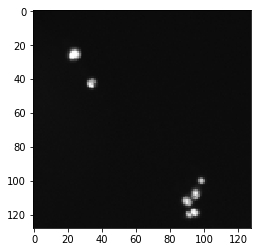

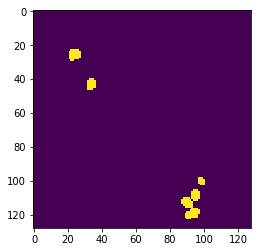

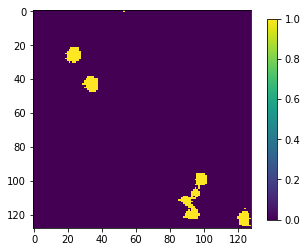

In [36]:
# Perform a sanity check on some random training samples

ix = random.randint(0, len(preds_train_t))

plt.imshow(X_train[ix],cmap=cm.jet,vmin=0,vmax=1)
plt.show()

plt.imshow(np.squeeze(Y_train[ix]))
plt.show()

plt.imshow(np.squeeze(preds_train_t[ix]), vmin=0, vmax=1)
plt.colorbar(fraction=.03)
plt.show()

In [41]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)


c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)


u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c2)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)


outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 128, 128, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 128, 128, 16) 448         lambda_9[0][0]                   
__________________________________________________________________________________________________
dropout_50 (Dropout)            (None, 128, 128, 16) 0           conv2d_104[0][0]                 
__________________________________________________________________________________________________
conv2d_105

In [43]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50)
                    callbacks=[earlystopper])

SyntaxError: invalid syntax (<ipython-input-43-f7c963fffae5>, line 5)